In [2]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain
from gerrychain.updaters import cut_edges
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.constraints import single_flip_contiguous
from gerrychain.random import random
from networkx import is_connected, connected_components

In [3]:
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import geopandas as gpd

In [4]:
# USER INPUTS

# county of interest. to keep all counties set to "ALL"
county = "Multnomah"

# number of districts
num_distr = 4

# target demographic column names in dataset, i.e. BVAP or NH_BLACK
# can be list of string or list of list of string or some combination of both
# i.e. ["BVAP"] or [["BVAP", "HVAP"], ["HVAP"]] or ["BVAP", ["HVAP", "AMINVAP"]] are all acceptable
dem_col = [["BVAP", "HVAP"], "HVAP", "BVAP"] 

# general population column name in dataset, i.e. VAP or TOTPOP
gen_col = "VAP"

# total population column name in dataset, i.e. TOTPOP
pop_col = "TOTPOP"

In [5]:
# wrap all dem_col inputs to be list of list of strings

def string_to_list(s): 
    if (type(s) == str):
        return [s]
    else:
        return s

dem_col = list(map(string_to_list, dem_col)) 

In [6]:
gdf = gpd.read_file("OR_precincts.shp")

In [7]:
# show columns of our dataset
gdf.columns

Index(['State', 'County', 'Precinct', 'Pct_Name', 'Shape_Leng', 'Shape_Area',
       'GOV18D', 'GOV18R', 'GOV18I', 'GOV18L', 'GOV18C', 'USH18D', 'USH18R',
       'PRES16D', 'PRES16R', 'PRES16L', 'PRES16G', 'SEN16D', 'SEN16R',
       'USH16D', 'USH16R', 'GOV16D', 'GOV16R', 'GOV16I', 'GOV16L', 'AG16D',
       'AG16R', 'SOS16D', 'SOS16R', 'SOS16I', 'SOS16G', 'SOS16L', 'CD',
       'HDIST', 'SEND', 'TOTPOP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'HISP', 'H_WHITE',
       'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP',
       'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP', 'geometry'],
      dtype='object')

In [8]:
if (county != "ALL"):
    gdf = gdf[gdf["County"] == county]

In [9]:
graph = Graph.from_geodataframe(gdf)
graph.add_data(gdf)

/Users/martingao/opt/anaconda3/envs/gerry/lib/python3.8/site-packages/gerrychain/graph/adjacency.py:66: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(131, 133), (35, 36), (26, 27), (122, 133), (30, 31), (125, 133)}
  warnings.warn(


In [10]:
# warns user if graph is not connected
if (is_connected(graph) == False):
    print("WARNING: GRAPH IS NOT CONNECTED")
    
# warns user if num of precincts is not significantly larger than num of districts
# specifically, the num of precincts must be larger by at least a factor of FACTOR
FACTOR = 4
if (len(gdf) < num_distr * FACTOR):
    print("WARNING: LOW NUMBER OF PRECINCTS RELATIVE TO NUMBER OF DISTRICTS")

In [11]:
# general updaters
myupdaters = {
    "population": updaters.Tally(pop_col, alias="population"),
    "general": updaters.Tally(gen_col, alias="general"),
}

# generate updaters related to demographic from user input
# updater aliases take the form "demographicBVAP" for BVAP
dem_updaters = {
    "demographic" + col: updaters.Tally(col, alias="demographic" + col) \
    for cols in dem_col for col in cols
}

# merge two dictionaries
myupdaters.update(dem_updaters)

In [12]:
total_population = sum([graph.nodes[n][pop_col] for n in graph.nodes])
assignment = recursive_tree_part(
    graph, 
    range(num_distr), #district names
    total_population/num_distr, #ideal population for a district
    pop_col, 
    0.05 #maximum allowed population deviation, 5% for now
)
# make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)

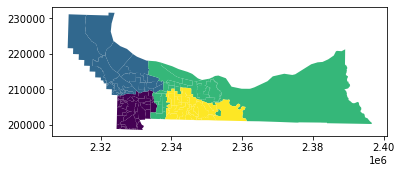

In [13]:
# sanity check: plot initial partition
initial_partition.plot(gdf)

In [14]:
myconstraints = [
    constraints.within_percent_of_ideal_population(initial_partition, 0.05)
]
myproposal = partial(
    recom,
    pop_col=pop_col,
    pop_target=total_population/4,
    epsilon=0.05, #population tolerance
    node_repeats=2 #parameter for spanning tree method, set to 2 is fine
)
chain = MarkovChain(
    proposal=myproposal,
    constraints=myconstraints,
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000 #just a few steps to start with
)

In [15]:
from collections import Counter

# takes a list of dicts, returns the dicts summed by key into one dict
def sum_dict_by_elm(dict_list):
    counter = Counter() 
    for d in dict_list:  
        counter.update(d)
    return dict(counter)

In [16]:
# make a list of empty lists the size of len(dem_col)
sharelists = [[] for i in range(len(dem_col))]

for i, step in enumerate(chain):
    gdf['recomstep{}'.format(i)] = [step.assignment[n] for n in graph.nodes] #store plan
    
    # calculate share for each dem_col given
    for i, cols in enumerate(dem_col):
        # create list of dicts containing population data for each demographic in coalition
        dict_list = [step["demographic" + col] for col in cols]
        
        # merge list of dicts into single list
        d1 = sum_dict_by_elm(dict_list)
        d2 = step["general"]
        
        # divide coalition dict over general dict to yield coalition share, and append to sharelists
        sharelists[i].append(sorted([d1[k]/d2[k] for k in d2]))

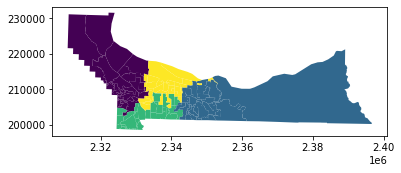

In [17]:
# sanity check: plot the 6th step of recom
gdf.plot(column="recomstep{}".format(5))

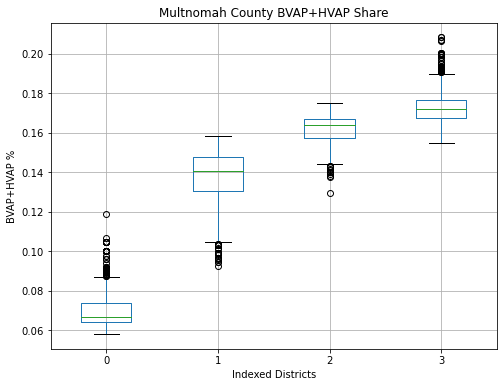

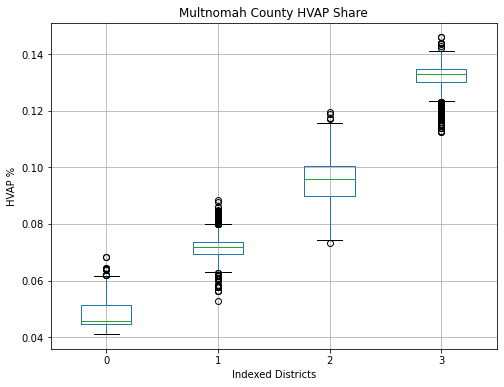

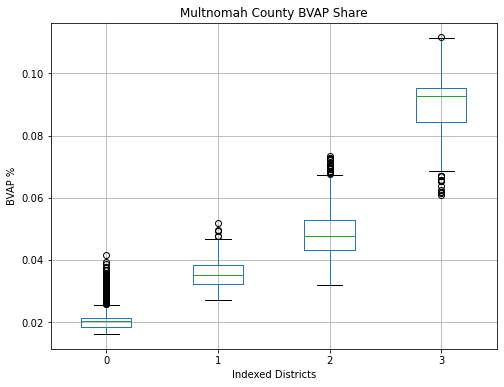

In [18]:
for i, col in enumerate(dem_col):
    share = pd.DataFrame(sharelists[i])

    fig, ax = plt.subplots(figsize=(8, 6))
    share.boxplot(ax=ax)

    label = '+'.join(dem_col[i])
    ax.set_title(county + " County " + label + " Share")
    ax.set_ylabel(label + " %")
    ax.set_xlabel("Indexed Districts")

    plt.show()